In [5]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


CUDA available: True
Device name: Quadro RTX 4000


In [1]:
#imports
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


/home/aaiteam4/anaconda3/envs/resume-ai/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
#loading the dataset
dataset = load_dataset("cnamuangtoun/resume-job-description-fit")

train.csv:   0%|          | 0.00/53.4M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/15.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1759 [00:00<?, ? examples/s]

In [4]:
train = dataset['train']
test = dataset['test']

In [6]:
train_data = pd.DataFrame(train)
test_data = pd.DataFrame(test)

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Precision: 0.4443
Recall:    0.4423
F1 Score:  0.4413


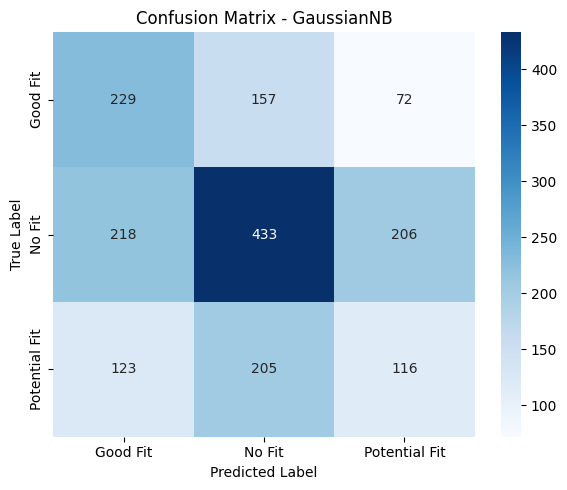

In [8]:
# 1. Imports
import numpy as np
import pandas as pd
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.naive_bayes import GaussianNB  # CHANGED: import GaussianNB for dense embeddings
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Preprocessing
def preprocess_text(text):
    return text.strip().lower()  # CHANGED: removed .lower() to preserve case

for col in ['resume_text', 'job_description_text']:
    train_data[col] = train_data[col].apply(preprocess_text)
    test_data[col] = test_data[col].apply(preprocess_text)

# 4. Sentence-BERT Embedding
embedder = SentenceTransformer('all-MiniLM-L6-v2')

def compute_dual_embeddings(resumes, job_descriptions):
    resume_embeds = embedder.encode(
        resumes,
        convert_to_tensor=False,
        batch_size=64,
        show_progress_bar=True
    )
    jd_embeds = embedder.encode(
        job_descriptions,
        convert_to_tensor=False,
        batch_size=64,
        show_progress_bar=True
    )
    return np.hstack((resume_embeds, jd_embeds))

# 5. Prepare data
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])
y_test = label_encoder.transform(test_data['label'])

X_train = compute_dual_embeddings(train_data['resume_text'], train_data['job_description_text'])
X_test = compute_dual_embeddings(test_data['resume_text'], test_data['job_description_text'])

# 6. Train classifier
clf = GaussianNB()  # CHANGED: using GaussianNB instead of LogisticRegression
clf.fit(X_train, y_train)

# 7. Evaluate
y_pred = clf.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# 8. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - GaussianNB")
plt.tight_layout()
plt.show()



In [9]:
# 10. Predict on Custom Resume + Job Description
def predict_fit(resume_text, job_description_text):
    resume_text = preprocess_text(resume_text)
    job_description_text = preprocess_text(job_description_text)
    embedding = compute_dual_embeddings([resume_text], [job_description_text])
    prediction = clf.predict(embedding)
    return label_encoder.inverse_transform(prediction)[0]

# Example usage
custom_resume = """Experienced software engineer with expertise in Python, Django, and REST API development. Worked on building scalable backend systems for e-commerce applications."""
custom_jd = """Looking for a backend developer skilled in Python and RESTful API design, preferably with Django experience."""

predicted_label = predict_fit(custom_resume, custom_jd)
print(f"Predicted Fit Category: {predicted_label}")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted Fit Category: Potential Fit


In [10]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity_scores(resume_embed, jd_embed):
    similarities = cosine_similarity(resume_embed, jd_embed)
    return np.diag(similarities)  # each resume vs its own JD

resume_embeds = X_test[:, :384]
jd_embeds = X_test[:, 384:]


similarity_scores = compute_similarity_scores(resume_embeds, jd_embeds)


threshold = 0.6  # Adjust based on your performance tuning

ml_predictions = clf.predict(X_test)
ml_labels = label_encoder.inverse_transform(ml_predictions)

intersection_indices = [
    i for i, (label, score) in enumerate(zip(ml_labels, similarity_scores))
    if label == 'Good Fit' and score >= threshold
]

# Optional: View or extract filtered results
filtered_results = test_data.iloc[intersection_indices]

# View intersected resume rows from the test set
intersected_resumes = test_data.iloc[intersection_indices][['resume_text', 'job_description_text']]
intersected_resumes.reset_index(drop=True, inplace=True)
print(intersected_resumes.head())

                                         resume_text  \
0  profilehas a master’s of science degree in man...   
1  professional summaryto obtain a full time oppo...   
2  professional summaryhighly regarded self-start...   
3  professional summaryenthusiastic computer engi...   
4  summaryhighly skilled and motivated senior sof...   

                                job_description_text  
0  gaming business analyst\n experience: 5+ yrs\n...  
1  who we are?for the past 20 years, we have powe...  
2  job summary\nmanage both strategic and daily d...  
3  job title: software developerlocation: clevela...  
4  you're ready to gain the skills and experience...  


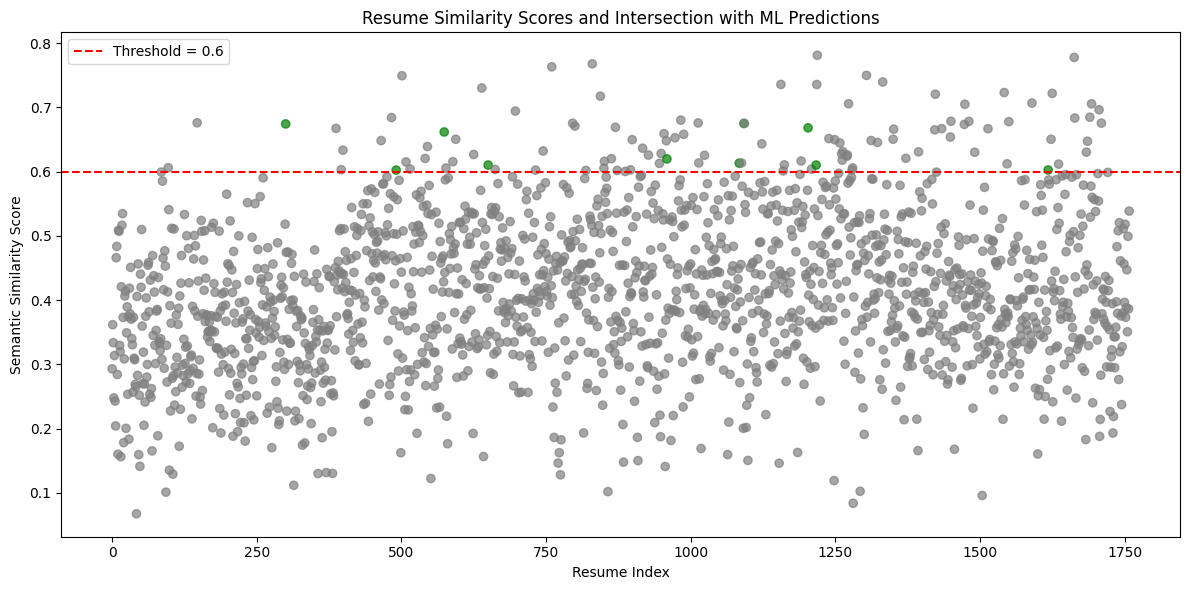

In [11]:
# Prepare color: green for intersection, gray otherwise
colors = ['green' if i in intersection_indices else 'gray' for i in range(len(similarity_scores))]

plt.figure(figsize=(12, 6))
plt.scatter(range(len(similarity_scores)), similarity_scores, c=colors, alpha=0.7)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Resume Index')
plt.ylabel('Semantic Similarity Score')
plt.title('Resume Similarity Scores and Intersection with ML Predictions')
plt.legend()
plt.tight_layout()
plt.show()